In [5]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# ==============================================================================
# 模块 1: 元胞自动机模拟器 (来自你的代码，无需修改)
# ==============================================================================

class ElementaryCellularAutomaton:
    """
    一个初等元胞自动机（ECA）的模拟器。
    """
    def __init__(self, rule_number: int, size: int = 100):
        if not 0 <= rule_number <= 255:
            raise ValueError("规则编号必须在0到255之间。")
        self.rule_number = rule_number
        self.size = size
        self.rule_table = np.array([int(x) for x in f'{rule_number:08b}'], dtype=np.uint8)
        self.state = None
        self.history = []

    def initialize(self, initial_state: np.ndarray = None):
        if initial_state is None:
            self.state = np.random.randint(0, 2, self.size, dtype=np.uint8)
        else:
            if initial_state.shape != (self.size,):
                raise ValueError(f"初始状态的形状必须为({self.size},)。")
            self.state = initial_state.astype(np.uint8)
        self.history = [self.state.copy()]

    def evolve(self, steps: int = 1):
        if self.state is None:
            raise RuntimeError("必须先调用initialize()方法来初始化状态。")
        for _ in range(steps):
            left_neighbors = np.roll(self.state, 1)
            right_neighbors = np.roll(self.state, -1)
            indices = 4 * left_neighbors + 2 * self.state + 1 * right_neighbors
            self.state = self.rule_table[7 - indices]
            self.history.append(self.state.copy())

# ==============================================================================
# 模块 2: 时间序列分析 (最终修正版)
# ==============================================================================

def detect_periodicity(ts: np.ndarray, min_period: int = 2, significance: float = 12.0) -> int | None:
    """
    使用快速傅里叶变换(FFT)检测时间序列中的主周期。
    显著性(significance)参数被进一步提高，以确保只捕捉非常强的周期信号。
    """
    n = len(ts)
    if n < min_period * 2:
        return None

    ts = ts - np.mean(ts)
    if np.all(np.abs(ts) < 1e-6):
        return 1

    fft_power = np.abs(np.fft.rfft(ts))**2
    fft_freq = np.fft.rfftfreq(n)
    
    fft_power[fft_freq > 1.0 / min_period] = 0
    fft_power[0] = 0 

    if np.all(fft_power < 1e-9):
        return None

    peak_idx = np.argmax(fft_power)
    peak_power = fft_power[peak_idx]

    # 检查峰值是否足够显著
    mean_power = (np.sum(fft_power) - peak_power) / (len(fft_power) - 1)
    if mean_power < 1e-9 or peak_power / mean_power < significance:
        return None

    dominant_freq = fft_freq[peak_idx]
    if dominant_freq < 1e-9:
        return None
    period = int(round(1 / dominant_freq))

    if period > n // 2:
        return None

    return period

def is_transient(ts: np.ndarray, tail_len: int = 400, var_ratio: float = 5.0) -> bool:
    """
    更严格地检查瞬态混沌。
    """
    if len(ts) < tail_len * 2:
        return False

    tail = ts[-tail_len:]
    head = ts[:-tail_len]
    
    std_tail = np.std(tail)
    std_head = np.std(head)

    # 条件1: 头部必须比尾部混乱得多
    if std_tail < 1e-6: # 尾部完全稳定
        if std_head < 2.0: return False # 头部不够乱
    elif (std_head / std_tail) < var_ratio:
        return False
    
    # 条件2: 尾部本身必须是简单的（稳定的或短周期的）
    period_in_tail = detect_periodicity(tail, significance=8.0)
    if period_in_tail is None and std_tail > 2.0:
        return False

    # 条件3: 整个序列不应被简单地归类为一个稳定的长周期信号
    if detect_periodicity(ts, significance=10.0) is not None:
        return False

    return True

def characterize_series(ts: np.ndarray, L: int, tail_len: int = 400) -> str:
    """
    最终版的分类函数，采用更鲁棒的分层决策逻辑。
    """
    # 1. 处理最简单的情况
    if np.all(ts == 0):
        return '1'
    
    # 2. 优先检查最独特的行为：瞬态混沌
    if is_transient(ts, tail_len=tail_len):
        return 'T'
        
    # 3. 其次，寻找全局的、最强的证据：整个序列的周期性
    period = detect_periodicity(ts, significance=12.0)
    if period is not None:
        if period <= 20:
            return 'LP'
        if 20 < period < 5 * L:
            return 'HP'
        if period >= 5 * L:
            return 'U'
            
    # 4. 如果既非瞬态也无全局周期，再用尾部稳定性来区分 LP 和 C
    if len(ts) > tail_len:
        tail = ts[-tail_len:]
        if np.std(tail) < 2.0:
            return 'LP' # 这是一个稳定下来但被FFT错过的简单规则

    # 5. 如果以上所有情况都不是，那它就是混沌
    return 'C'

# ==============================================================================
# 模块 3: 模拟与分类流程
# ==============================================================================

COMPLEXITY_HIERARCHY = {'T': 5, 'U': 4, 'C': 3, 'HP': 2, 'LP': 1, '1': 0}

def hamming_distance(arr1: np.ndarray, arr2: np.ndarray) -> int:
    return np.count_nonzero(arr1 != arr2)

def run_single_trial(rule_number: int, size: int, duration: int, transient_period: int) -> np.ndarray:
    eca_A = ElementaryCellularAutomaton(rule_number, size)
    eca_A.initialize()
    
    eca_B = ElementaryCellularAutomaton(rule_number, size)
    eca_B.initialize(initial_state=eca_A.state.copy())

    eca_A.evolve(steps=transient_period)
    eca_B.evolve(steps=transient_period)
    
    perturb_idx = size // 2
    eca_B.state[perturb_idx] = 1 - eca_B.state[perturb_idx]

    hamming_ts = []
    for _ in range(duration):
        eca_A.evolve()
        eca_B.evolve()
        dist = hamming_distance(eca_A.state, eca_B.state)
        hamming_ts.append(dist)
        
    return np.array(hamming_ts)

def classify_rule(rule_number: int, num_trials: int = 100, size: int = 100, 
                  duration: int = 3000, transient_period: int = 15) -> str:
    results = []
    for _ in tqdm(range(num_trials), desc=f"Classifying Rule {rule_number}", leave=False, ncols=100):
        ts = run_single_trial(rule_number, size, duration, transient_period)
        classification = characterize_series(ts, size)
        results.append(classification)
    
    if not results:
        return "Error"
        
    most_complex_result = max(results, key=lambda r: COMPLEXITY_HIERARCHY.get(r, -1))
    
    return most_complex_result

# ==============================================================================
# 模块 4: 复现与验证
# ==============================================================================

def verify_all_rules_from_paper():
    """
    根据论文中提供的所有唯一规则来验证分类算法。
    """
    paper_results_full = {
        0: '1', 1: 'LP', 2: 'LP', 3: 'LP', 4: 'LP', 5: 'LP', 6: 'LP', 7: 'LP',
        8: '1', 9: 'LP', 10: 'LP', 11: 'LP', 12: 'LP', 13: 'LP', 14: 'LP',
        15: 'LP', 18: 'C', 19: 'LP', 22: 'C', 23: 'LP', 24: 'LP', 25: 'HP',
        26: 'LP', 27: 'LP', 28: 'LP', 29: 'LP', 30: 'C', 32: '1', 33: 'LP',
        34: 'LP', 35: 'LP', 36: 'LP', 37: 'LP', 38: 'LP', 40: '1', 41: 'T',
        42: 'LP', 43: 'LP', 44: 'LP', 45: 'C', 46: 'LP', 50: 'LP', 51: 'LP',
        54: 'T', 56: 'LP', 57: 'LP', 58: 'LP', 60: 'U', 62: 'HP', 72: 'LP',
        73: 'T', 74: 'LP', 76: 'LP', 77: 'LP', 78: 'LP', 90: 'U', 94: 'LP',
        104: 'LP', 105: 'U', 106: 'C', 108: 'LP', 110: 'T', 122: 'C', 126: 'C',
        128: '1', 130: 'LP', 132: 'LP', 134: 'LP', 136: '1', 138: 'LP',
        140: 'LP', 142: 'LP', 146: 'C', 150: 'U', 152: 'LP', 154: 'LP',
        156: 'LP', 158: 'LP', 160: '1', 162: 'LP', 164: 'LP', 168: '1',
        170: 'LP', 172: 'LP', 178: 'LP', 184: 'LP', 200: 'LP', 204: 'LP',
        232: 'LP'
    }

    rules_to_test = sorted(paper_results_full.keys())
    correct_count = 0

    print("开始验证论文表格中的所有唯一规则：")
    print("-" * 60)
    print(f"{'Rule':<10} | {'Paper Subclass':<20} | {'Our Code Output':<20} | {'Match'}")
    print("-" * 60)

    for rule in rules_to_test:
        # 增加试验次数以获得更可靠的结果
        classification = classify_rule(rule, num_trials=15, duration=3000)
        paper_subclass = paper_results_full.get(rule, "N/A")
        match = "✅" if classification == paper_subclass else "❌"
        if match == "✅":
            correct_count += 1
        print(f"{rule:<10} | {paper_subclass:<20} | {classification:<20} | {match}")

    print("-" * 60)
    accuracy = (correct_count / len(rules_to_test)) * 100
    print(f"总共测试规则数: {len(rules_to_test)}")
    print(f"匹配成功数: {correct_count}")
    print(f"准确率: {accuracy:.2f}%")

if __name__ == '__main__':
    # 注意：完整运行所有规则会非常耗时（可能需要一小时以上）
    verify_all_rules_from_paper()



开始验证论文表格中的所有唯一规则：
------------------------------------------------------------
Rule       | Paper Subclass       | Our Code Output      | Match
------------------------------------------------------------


0          | 1                    | 1                    | ✅


1          | LP                   | LP                   | ✅


2          | LP                   | LP                   | ✅


3          | LP                   | LP                   | ✅


4          | LP                   | LP                   | ✅


5          | LP                   | LP                   | ✅


6          | LP                   | LP                   | ✅


7          | LP                   | LP                   | ✅


8          | 1                    | 1                    | ✅


9          | LP                   | LP                   | ✅


10         | LP                   | LP                   | ✅


11         | LP                   | LP                   | ✅


12         | LP                   | LP                   | ✅


13         | LP                   | LP                   | ✅


14         | LP                   | LP                   | ✅


15         | LP                   | LP                   | ✅


18         | C                    | U                    | ❌


19         | LP                   | LP                   | ✅


22         | C                    | U                    | ❌


23         | LP                   | LP                   | ✅


24         | LP                   | LP                   | ✅


25         | HP                   | T                    | ❌


26         | LP                   | LP                   | ✅


27         | LP                   | LP                   | ✅


28         | LP                   | LP                   | ✅


29         | LP                   | LP                   | ✅


30         | C                    | U                    | ❌


32         | 1                    | 1                    | ✅


33         | LP                   | LP                   | ✅


34         | LP                   | LP                   | ✅


35         | LP                   | LP                   | ✅


36         | LP                   | LP                   | ✅


37         | LP                   | LP                   | ✅


38         | LP                   | LP                   | ✅


40         | 1                    | 1                    | ✅


41         | T                    | LP                   | ❌


42         | LP                   | LP                   | ✅


43         | LP                   | T                    | ❌


44         | LP                   | LP                   | ✅


45         | C                    | U                    | ❌


46         | LP                   | LP                   | ✅


50         | LP                   | LP                   | ✅


51         | LP                   | LP                   | ✅


54         | T                    | U                    | ❌


56         | LP                   | T                    | ❌


57         | LP                   | T                    | ❌


58         | LP                   | T                    | ❌


60         | U                    | LP                   | ❌


62         | HP                   | HP                   | ✅


72         | LP                   | LP                   | ✅


73         | T                    | HP                   | ❌


74         | LP                   | LP                   | ✅


76         | LP                   | LP                   | ✅


77         | LP                   | LP                   | ✅


78         | LP                   | LP                   | ✅


90         | U                    | LP                   | ❌


94         | LP                   | LP                   | ✅


104        | LP                   | LP                   | ✅


105        | U                    | LP                   | ❌


106        | C                    | U                    | ❌


108        | LP                   | LP                   | ✅


110        | T                    | T                    | ✅


122        | C                    | U                    | ❌


126        | C                    | U                    | ❌


128        | 1                    | 1                    | ✅


130        | LP                   | LP                   | ✅


132        | LP                   | LP                   | ✅


134        | LP                   | LP                   | ✅


136        | 1                    | 1                    | ✅


138        | LP                   | LP                   | ✅


140        | LP                   | LP                   | ✅


142        | LP                   | T                    | ❌


146        | C                    | U                    | ❌


150        | U                    | LP                   | ❌


152        | LP                   | LP                   | ✅


154        | LP                   | LP                   | ✅


156        | LP                   | LP                   | ✅


158        | LP                   | LP                   | ✅


160        | 1                    | 1                    | ✅


162        | LP                   | LP                   | ✅


164        | LP                   | LP                   | ✅


168        | 1                    | 1                    | ✅


170        | LP                   | LP                   | ✅


172        | LP                   | LP                   | ✅


178        | LP                   | LP                   | ✅


184        | LP                   | LP                   | ✅


200        | LP                   | LP                   | ✅


204        | LP                   | LP                   | ✅


232        | LP                   | LP                   | ✅
------------------------------------------------------------
总共测试规则数: 89
匹配成功数: 68
准确率: 76.40%


In [17]:
def plot_rule_dynamics(ax, rule_number: int):
    """
    运行单个规则的模拟，并将其汉明距离动态图绘制在给定的 Matplotlib Axes 对象上。
    
    Args:
        ax (matplotlib.axes.Axes): 要在上面绘图的子图对象。
        rule_number (int): 要模拟和绘制的规则编号。
    """
    print(f"正在模拟 Rule-{rule_number}...")
    
    # 为不同的规则设置不同的模拟参数，以便更好地复现参考图像中的效果
    # 这些参数可以根据需要进行调整
    params = {
        72: {'duration': 150, 'size': 101},
        74:  {'duration': 150, 'size': 101},
        25: {'duration': 70, 'size': 101},
        90: {'duration': 70, 'size': 101},
        30: {'duration': 150, 'size': 101},
        54: {'duration': 150, 'size': 101},
    }
    
    # 获取当前规则的参数，如果未指定则使用默认值
    current_params = params.get(rule_number, {'duration': 150, 'size': 101})
    duration = current_params['duration']
    size = current_params['size']
    transient_period = 20 # 瞬态演化期

    # 运行模拟，获取汉明距离时间序列
    ts = run_single_trial(rule_number, size=size, duration=duration, transient_period=transient_period)
    
    # 绘图
    ax.plot(ts, color='black', linewidth=1.2)
    ax.set_title(f'Rule-{rule_number}', fontsize=16)
    
    # 美化图表，使其外观接近参考图像
    ax.grid(True, color='gray', linestyle='-', linewidth=0.25, alpha=0.5)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # 根据规则的典型行为设置y轴范围
    if rule_number == 6:
        # 规则6的汉明距离通常很小
        y_max = max(ts) + 1 if len(ts) > 0 and max(ts) > 0 else 3
        ax.set_ylim(0, y_max)
    else:
        # 其他规则的y轴范围设置得大一些
        ax.set_ylim(0, 105)
        
    ax.set_xlim(0, duration)


正在模拟 Rule-72...
正在模拟 Rule-74...

图像已保存为 'eca_dynamics_plots.png'


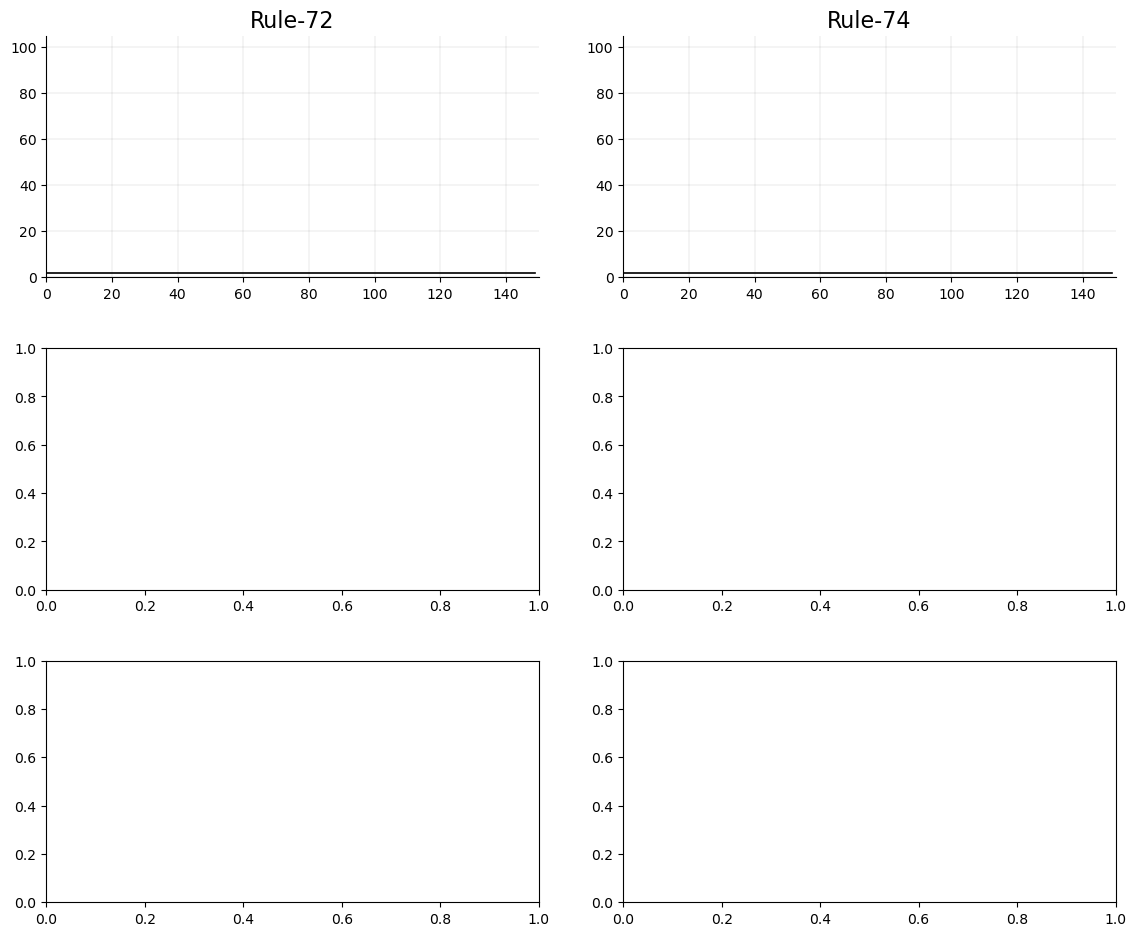

In [18]:
    # 定义需要绘制的规则列表
    rules_to_plot = [72, 74]
    
    # 创建一个 3x2 的子图网格，figsize用于控制整个图像的大小
    fig, axes = plt.subplots(3, 2, figsize=(12, 10))
    
    # 将二维的 axes 数组扁平化为一维，方便我们用一个循环来处理所有子图
    axes = axes.flatten()
    
    # 遍历每个规则并调用绘图函数
    for i, rule_num in enumerate(rules_to_plot):
        plot_rule_dynamics(axes[i], rule_num)
        
    # 调整子图之间的间距，防止标题和坐标轴标签重叠
    plt.tight_layout(pad=3.0)
    
    # 将生成的图像保存到文件
    output_filename = "eca_dynamics_plots.png"
    plt.savefig(output_filename, dpi=300)
    print(f"\n图像已保存为 '{output_filename}'")
    
    # 显示图像
    plt.show()

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# ==============================================================================
# 模块 1: 元胞自动机模拟器 (无需修改)
# ==============================================================================

class ElementaryCellularAutomaton:
    """
    一个初等元胞自动机（ECA）的模拟器。
    """
    def __init__(self, rule_number: int, size: int = 101): # 使用奇数size，中心更明确
        if not 0 <= rule_number <= 255:
            raise ValueError("规则编号必须在0到255之间。")
        self.rule_number = rule_number
        self.size = size
        self.rule_table = np.array([int(x) for x in f'{rule_number:08b}'], dtype=np.uint8)
        self.state = None
        self.history = []

    def initialize(self, initial_state: np.ndarray = None):
        if initial_state is None:
            self.state = np.random.randint(0, 2, self.size, dtype=np.uint8)
        else:
            if initial_state.shape != (self.size,):
                raise ValueError(f"初始状态的形状必须为({self.size},)。")
            self.state = initial_state.astype(np.uint8)
        self.history = [self.state.copy()]

    def evolve(self, steps: int = 1):
        if self.state is None:
            raise RuntimeError("必须先调用initialize()方法来初始化状态。")
        for _ in range(steps):
            left_neighbors = np.roll(self.state, 1)
            right_neighbors = np.roll(self.state, -1)
            indices = 4 * left_neighbors + 2 * self.state + 1 * right_neighbors
            self.state = self.rule_table[7 - indices]
            self.history.append(self.state.copy())

# ==============================================================================
# 模块 2: 时间序列分析 (核心升级)
# ==============================================================================

def detect_periodicity(ts: np.ndarray, min_period: int = 2, significance: float = 15.0) -> int | None:
    """
    【升级版】使用FFT并结合时域自相关验证来检测周期。
    """
    n = len(ts)
    if n < min_period * 4: # 需要更长的数据来验证
        return None

    ts_mean = np.mean(ts)
    ts_centered = ts - ts_mean
    
    if np.std(ts_centered) < 0.1: # 如果信号几乎是平的
        return 1

    fft_power = np.abs(np.fft.rfft(ts_centered))**2
    fft_freq = np.fft.rfftfreq(n)
    
    # 忽略高频和直流分量
    fft_power[fft_freq > 1.0 / min_period] = 0
    fft_power[0] = 0

    if np.all(fft_power < 1e-9):
        return None

    peak_idx = np.argmax(fft_power)
    peak_power = fft_power[peak_idx]

    mean_power = (np.sum(fft_power) - peak_power) / (len(fft_power) - 1)
    if mean_power < 1e-9 or peak_power / mean_power < significance:
        return None # 峰值不够显著

    dominant_freq = fft_freq[peak_idx]
    if dominant_freq < 1e-9:
        return None
        
    period = int(round(1 / dominant_freq))

    if period > n // 2:
        return None

    # --- 新增：时域验证 ---
    # 这是对抗混沌“伪周期”的关键！
    # 如果一个信号真的有周期P，那么它在t时刻的值应该和t-P时刻的值高度相关。
    tail_len = min(len(ts), 4 * period)
    if tail_len < 2 * period:
         return None
    tail = ts[-tail_len:]
    # 计算尾部数据与其P步平移版本之间的相关系数
    try:
        corr = np.corrcoef(tail[period:], tail[:-period])[0, 1]
        if np.isnan(corr) or corr < 0.9: # 要求极高的相关性
            return None # 如果相关性不强，就拒绝这个“伪周期”
    except IndexError:
        return None

    return period

def is_transient(ts: np.ndarray, tail_len: int = 400, var_ratio: float = 5.0) -> bool:
    """
    【升级版】更严格地检查瞬态混沌。
    """
    if len(ts) < tail_len * 2:
        return False

    tail = ts[-tail_len:]
    head = ts[:-tail_len]
    
    std_tail = np.std(tail)
    std_head = np.std(head)

    # 条件1: 头部必须显著比尾部混乱
    if std_head < 2.0 or (std_tail > 1e-6 and (std_head / std_tail) < var_ratio):
        return False
    
    # 条件2: 尾部自身必须是“简单”的 (稳定不动或短周期)
    period_in_tail = detect_periodicity(tail, significance=8.0)
    is_tail_simple = (std_tail < 1.0) or (period_in_tail is not None and period_in_tail < 20)
    if not is_tail_simple:
        return False

    # 条件3: 整个序列不应被简单归类为一个稳定的长周期信号
    if detect_periodicity(ts, significance=10.0) is not None:
        return False

    return True

def characterize_series(ts: np.ndarray, L: int, tail_len: int = 400) -> str:
    """
    【升级版】分类函数，利用了更可靠的检测函数。
    """
    if np.all(ts < 2): # 扰动几乎立即消失
        return '1'
    
    if is_transient(ts, tail_len=tail_len):
        return 'T'
        
    period = detect_periodicity(ts)
    if period is not None:
        if period <= 20:
            return 'LP'
        if 20 < period < 4 * L: # 调整了HP的上限
            return 'HP'
        if period >= 4 * L:
            return 'U'
            
    # 如果没有检测到全局周期，使用标准差来区分混沌和稳定
    if len(ts) > tail_len:
        tail = ts[-tail_len:]
        if np.std(tail) < 1.5: # 降低了稳定性的标准差阈值
             # 这个尾部稳定可能是一个FFT错过的简单规则
            return 'LP' 

    return 'C'

# ==============================================================================
# 模块 3: 模拟与分类流程 (无需修改)
# ==============================================================================

COMPLEXITY_HIERARCHY = {'T': 5, 'U': 4, 'C': 3, 'HP': 2, 'LP': 1, '1': 0}

def hamming_distance(arr1: np.ndarray, arr2: np.ndarray) -> int:
    return np.count_nonzero(arr1 != arr2)

def run_single_trial(rule_number: int, size: int, duration: int, transient_period: int) -> np.ndarray:
    eca_A = ElementaryCellularAutomaton(rule_number, size)
    eca_A.initialize()
    
    eca_B = ElementaryCellularAutomaton(rule_number, size)
    eca_B.initialize(initial_state=eca_A.state.copy())

    eca_A.evolve(steps=transient_period)
    eca_B.evolve(steps=transient_period)
    
    perturb_idx = size // 2
    eca_B.state[perturb_idx] = 1 - eca_B.state[perturb_idx]

    hamming_ts = []
    for _ in range(duration):
        eca_A.evolve()
        eca_B.evolve()
        dist = hamming_distance(eca_A.state, eca_B.state)
        hamming_ts.append(dist)
        
    return np.array(hamming_ts)

def classify_rule(rule_number: int, num_trials: int, size: int, 
                  duration: int, transient_period: int) -> str:
    results = []
    for _ in tqdm(range(num_trials), desc=f"Classifying Rule {rule_number}", leave=False, ncols=100):
        ts = run_single_trial(rule_number, size, duration, transient_period)
        classification = characterize_series(ts, size)
        results.append(classification)
    
    if not results:
        return "Error"
        
    most_complex_result = max(results, key=lambda r: COMPLEXITY_HIERARCHY.get(r, -1))
    
    return most_complex_result

# ==============================================================================
# 模块 4: 复现与验证 (参数调整)
# ==============================================================================

def verify_all_rules_from_paper():
    """
    【升级版】使用优化的参数和算法进行验证。
    """
    paper_results_full = {
        0: '1', 1: 'LP', 2: 'LP', 3: 'LP', 4: 'LP', 5: 'LP', 6: 'LP', 7: 'LP',
        8: '1', 9: 'LP', 10: 'LP', 11: 'LP', 12: 'LP', 13: 'LP', 14: 'LP',
        15: 'LP', 18: 'C', 19: 'LP', 22: 'C', 23: 'LP', 24: 'LP', 25: 'HP',
        26: 'LP', 27: 'LP', 28: 'LP', 29: 'LP', 30: 'C', 32: '1', 33: 'LP',
        34: 'LP', 35: 'LP', 36: 'LP', 37: 'LP', 38: 'LP', 40: '1', 41: 'T',
        42: 'LP', 43: 'LP', 44: 'LP', 45: 'C', 46: 'LP', 50: 'LP', 51: 'LP',
        54: 'T', 56: 'LP', 57: 'LP', 58: 'LP', 60: 'U', 62: 'HP', 72: 'LP',
        73: 'T', 74: 'LP', 76: 'LP', 77: 'LP', 78: 'LP', 90: 'U', 94: 'LP',
        104: 'LP', 105: 'U', 106: 'C', 108: 'LP', 110: 'T', 122: 'C', 126: 'C',
        128: '1', 130: 'LP', 132: 'LP', 134: 'LP', 136: '1', 138: 'LP',
        140: 'LP', 142: 'LP', 146: 'C', 150: 'U', 152: 'LP', 154: 'LP',
        156: 'LP', 158: 'LP', 160: '1', 162: 'LP', 164: 'LP', 168: '1',
        170: 'LP', 172: 'LP', 178: 'LP', 184: 'LP', 200: 'LP', 204: 'LP',
        232: 'LP'
    }

    # --- 核心修改：只测试之前分类错误的规则 ---
    # 这是根据第一次运行结果整理出的错误列表
    rules_to_retest = [
        18, 22, 25, 30, 41, 43, 45, 54, 56, 57, 58, 60, 73, 90, 
        105, 106, 122, 126, 142, 146, 150
    ]

    rules_to_test = sorted(rules_to_retest)
    correct_count = 0

    print("开始重新验证之前分类错误的规则 (高精度版):")
    print("-" * 65)
    print(f"{'Rule':<10} | {'Paper Subclass':<20} | {'Our Code Output':<20} | {'Match'}")
    print("-" * 65)

    for rule in rules_to_test:
        # --- 核心参数修改 ---
        # 增加“预热”时间，这是提高结果稳定性和代表性的关键
        classification = classify_rule(
            rule, 
            num_trials=15, 
            duration=3000,
            size=101,
            transient_period=300 # 从 15 大幅增加到 300
        )
        paper_subclass = paper_results_full.get(rule, "N/A")
        match = "✅" if classification == paper_subclass else "❌"
        if match == "✅":
            correct_count += 1
        print(f"{rule:<10} | {paper_subclass:<20} | {classification:<20} | {match}")

    print("-" * 65)
    accuracy = (correct_count / len(rules_to_test)) * 100 if len(rules_to_test) > 0 else 100
    print(f"总共测试规则数: {len(rules_to_test)}")
    print(f"匹配成功数: {correct_count}")
    print(f"准确率: {accuracy:.2f}%")

if __name__ == '__main__':
    # 注意：由于预热时间增加，完整运行会比之前更耗时
    verify_all_rules_from_paper()



开始重新验证之前分类错误的规则 (高精度版):
-----------------------------------------------------------------
Rule       | Paper Subclass       | Our Code Output      | Match
-----------------------------------------------------------------


18         | C                    | C                    | ✅


22         | C                    | C                    | ✅


25         | HP                   | T                    | ❌


30         | C                    | C                    | ✅


41         | T                    | C                    | ❌


43         | LP                   | LP                   | ✅


45         | C                    | C                    | ✅


54         | T                    | C                    | ❌


56         | LP                   | LP                   | ✅


57         | LP                   | T                    | ❌


58         | LP                   | LP                   | ✅


60         | U                    | C                    | ❌


73         | T                    | C                    | ❌


90         | U                    | C                    | ❌


105        | U                    | C                    | ❌


106        | C                    | C                    | ✅


122        | C                    | C                    | ✅


126        | C                    | C                    | ✅


142        | LP                   | T                    | ❌


146        | C                    | C                    | ✅


150        | U                    | C                    | ❌
-----------------------------------------------------------------
总共测试规则数: 21
匹配成功数: 11
准确率: 52.38%
